# NLP: Toxic Comment Classification

**An aim of the research** — search and identification of toxic comments in the text:
1. PyTorch application with pretrained model BERT and Logistic regression based on neural network
2. Scikit-learn application with TF-IDF statistical model
3. PySpark application with the Bag of Words vectorization model

**An initial data**

The dataframe is extracted from the file `toxic_comments.csv`.

Since the text should be in its original state after writing the comments, there is no need to additionally preprocess the data.
 
The research is divided into four steps:
  1. Data overview
  2. Text processing with PyTorch BERT
  3. Text processing with Scikit-learn
  4. Text processing with PySpark

### Step 1. Data overview

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import udf, lit, col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer as CountVectorizerSpark
from pyspark.ml.classification import LogisticRegression as LogisticRegressionSpark
from pyspark.ml import Pipeline as PipelineSpark
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizerSklearn
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline as PipelineSklearn
from sklearn.model_selection import GridSearchCV

from transformers.models.bert.tokenization_bert import BasicTokenizer
from tqdm import notebook
from IPython.display import Image
from IPython.core.display import HTML 
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

import re
import nltk
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

In [2]:
# download package 'wordnet'
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# initialize spark session and context
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

In [5]:
# set global parameters 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')

In [6]:
# seed the RNG
torch.manual_seed(777)

In [7]:
# define path to directory
path1 = '/datasets/toxic_comments.csv'
path2 = 'C:/YandexPracticumProjects/Project_13_TextProcessing_ML/toxic_comments.csv'

In [8]:
# read 'toxic_comments.csv' in pandas environment
try:
    df_panda = pd.read_csv(path1)
except:  
    df_panda = pd.read_csv(path2)

df_panda.loc[0:4].style

,Unnamed: 0,text,toxic
0,0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [9]:
# general info
df_panda.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 81.1 MB


In [10]:
# read 'toxic_comments.csv' in pyspark environment 
try:
    df_spark = spark.read.csv(path1)
    df_spark = spark.read.option('header', True).option('inferSchema', True).csv(path1)
except:  
    df_spark = spark.read.csv(path2)
    df_spark = spark.read.option('header', True).option('inferSchema', True).csv(path2)

In [11]:
# show 5 rows
df_spark.show(5)

+--------------------+--------------------+-----+
|                 _c0|                text|toxic|
+--------------------+--------------------+-----+
|                   0|         Explanation| null|
|Why the edits mad...| just closure on ...|    0|
|                   1|D'aww! He matches...|    0|
|                   2|Hey man, I'm real...|    0|
|                   3|                   "| null|
+--------------------+--------------------+-----+
only showing top 5 rows



In [12]:
# print out schema
df_spark.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- text: string (nullable = true)
 |-- toxic: string (nullable = true)



In [13]:
# type of data
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [14]:
# rename target column and drop NaN values
df_panda = df_panda.rename(columns={'toxic': 'label'})\
                   .dropna()\
                   .drop(columns=['Unnamed: 0'])

In [15]:
# rename target column, drop NaN values and filter labels
df_spark = df_spark.withColumnRenamed('toxic', 'label_')\
                   .na.drop()\
                   .drop('_c0')\
                   .filter((df_spark.toxic == '0') | (df_spark.toxic == '1'))

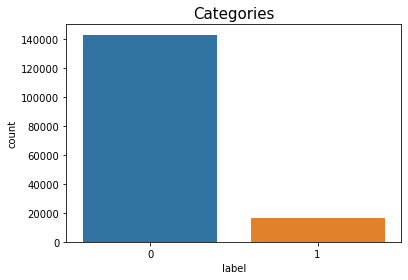

In [16]:
# ratio of labels
sns.countplot(x='label', data=df_panda).set_title('Categories', fontsize=15);

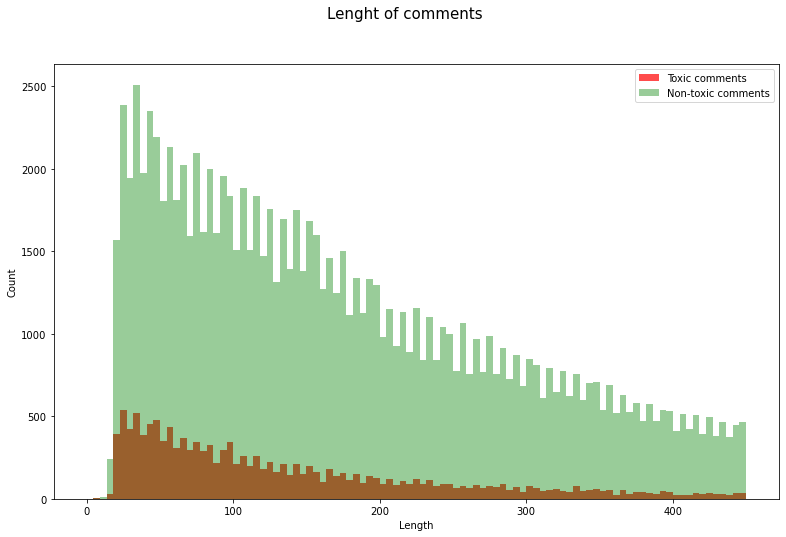

In [17]:
# plot lenght of comments
label_1 = df_panda[df_panda['label'] == 1]['text'].apply(lambda x: len(x) - len(' '))
label_2 = df_panda[df_panda['label'] == 0]['text'].apply(lambda x: len(x) - len(' '))
bins_ = np.linspace(0, 450, 100)
plt.figure(figsize=(13, 8)).suptitle('Lenght of comments', fontsize=15)
plt.xlabel('Length')
plt.ylabel('Count')
plt.hist(label_1, bins=bins_, alpha=0.7, label='Toxic comments', color='red')
plt.hist(label_2, bins=bins_, alpha=0.4, label='Non-toxic comments', color='green')
plt.legend();

When converting text data from csv format by the PySpark library, part of the text ends up in the target column. Also, some of the data is converted to null. As a consequence, a filter is applied to clean up the data. There are no such problems with the Pandas library.

The data represents two categories: Toxic and Non-toxic comments. The length of the largest number of comments is between 0 and 100 words. At the same time, toxic comments are about 7 times less.

### Step 2. Text processing with PyTorch BERT

In [18]:
# PyTorch BERT
Image(url='https://miro.medium.com/max/720/0*ViwaI3Vvbnd-CJSQ.png', 
      width=600, height=400
)

In [19]:
# count number of characters
df_panda['count'] = df_panda['text'].str.len()
df_panda.sort_values(by='count', ascending=False).head(5)

,text,label,count
75033,IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN T...,0,5000
46480,hahahahahahahahahahahahahahahahahaha vandalism...,1,5000
72066,China smells like fart. China smells like fart...,1,5000
96100,BOOTSTOOTS IS A FRIGGEN GAYFAG LOLOOOLBOOTSTOO...,1,5000
53300,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,1,5000


In [21]:
# create reduced dataframe by sampling from  
reduced_df = df_panda.sample(3000).reset_index(drop=True) 

In [22]:
# display tokenized text
tokenizer_temp = BasicTokenizer(do_lower_case=False)
tokenized_temp = reduced_df['text'].apply(lambda x: tokenizer_temp.tokenize(x))
display(tokenized_temp.head())

0    [You, can, ', t, change, the, map, now, ., It,...
1                 [or, denigrating, the, majority, of]
2    [", Hello, I, see, that, you, have, returned, ...
3    [", In, addition, ,, it, annoys, me, that, in,...
4    [this, also, ponders, my, imagination, i, say,...
Name: text, dtype: object

In [23]:
# load pretrained tokenizer
try:    
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
    tokenized = reduced_df['text'].apply(
        lambda x: tokenizer.encode(
            x, add_special_tokens=True, truncation=True, max_length=512
        )
    )
except:
    tokenizer = transformers.BertTokenizer(
        vocab_file='C:/YandexPracticumProjects/Project_13_TextProcessing_ML/vocab.txt'
    )
    tokenized = reduced_df['text'].apply(
        lambda x: tokenizer.encode(
            x, add_special_tokens=True, truncation=True, max_length=512
        )
    )

In [24]:
# display vectorized text
display(tokenized.head())

0    [101, 1192, 1169, 112, 189, 1849, 1103, 4520, ...
1    [101, 1137, 10552, 6512, 7969, 1103, 2656, 110...
2    [101, 107, 8667, 146, 1267, 1115, 1128, 1138, ...
3    [101, 107, 1130, 1901, 117, 1122, 1126, 21244,...
4    [101, 1142, 1145, 11925, 1468, 1139, 10405, 17...
Name: text, dtype: object

In [25]:
# print out size of vector
tokenized.shape

(3000,)

In [26]:
# pad all lists to the same size to represent the input as one 2-d array
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])   
np.array(padded).shape   

(3000, 512)

In [27]:
# create a variable to ignore (mask) the padding when processing its input
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3000, 512)

In [28]:
# load pretrained model and config file
try:
    model = transformers.BertModel.from_pretrained('bert-base-cased')
except:
    config = transformers.BertConfig.from_json_file(
        'C:/YandexPracticumProjects/Project_13_TextProcessing_ML/bert_config.json'
    )
    model = transformers.BertModel.from_pretrained(
        'C:/YandexPracticumProjects/Project_13_TextProcessing_ML/bert-base-cased-pytorch_model.bin', 
        config=config
    )

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
# run sentences through BERT
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:, 0, :].numpy())

  0%|          | 0/30 [00:00<?, ?it/s]

In [30]:
# create features and target for ML model
features = np.concatenate(embeddings)
target = reduced_df['label'] 

In [31]:
# convert data to pytorch tensors
X_torch = torch.tensor(features)
y_torch= torch.tensor(target)

In [32]:
# split data into train and test by 70/30
X_train_pytorch, X_test_pytorch, y_train_pytorch, y_test_pytorch = train_test_split(
    X_torch, 
    y_torch, 
    test_size=0.3, 
    random_state=777, 
    stratify=y_torch
)

In [33]:
# set hyper-parameters
EPOCHS = 500+1
PRINT_EPOCH = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 16

In [34]:
# define dataset class
class Data(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len    

In [35]:
# create data for training
train_data_pytorch = Data(X_train_pytorch, y_train_pytorch)
test_data_pytorch = Data(X_test_pytorch, y_test_pytorch)

# train dataloader
train_loader = DataLoader(
    dataset=train_data_pytorch, 
    batch_size=BATCH_SIZE,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

# test dataloader
test_loader = DataLoader(
    dataset=test_data_pytorch, 
    batch_size=BATCH_SIZE,  
    num_workers=0, 
    shuffle=True, 
    pin_memory=False
)

In [36]:
# define the network
class LogRegPytorch(nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogRegPytorch, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs  

In [37]:
# model, loss, optimizer
model_pytorch = LogRegPytorch(X_train_pytorch.shape[1], 1)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_pytorch.parameters(), lr=LEARNING_RATE)    

In [38]:
# calculate accuracy
def accuracy(y_pred, y):
    return torch.sum((y_pred >= 0.5).reshape(1, -1) == y).item() / y.shape[0]

In [39]:
# train the model
def training(train_loader, model, optimizer):
    
    train_result = [] 
    for epoch in range(EPOCHS):
        
        iter_loss = 0 
        iter_acc = 0                   
        
        # model training
        model.train()
        for i, data in enumerate(train_loader):
            X, y = data             # (predictors, targets)
            oupt = model(X.float()) # predicted values
            loss = criterion(oupt, y.reshape(-1, 1).float())

            iter_loss += loss       # avg per item in batch
            iter_acc += accuracy(oupt, y)

            optimizer.zero_grad()   # prepare gradients
            loss.backward()         # compute gradients
            optimizer.step()        # update weights

            if(epoch == EPOCHS - 1):
                train_result.append((y, ((oupt >= 0.5) + 0).reshape(1, -1)[0]))

        if(epoch % PRINT_EPOCH == 0):
            print('Train: epoch: {0} | loss: {1:.5f} | acc: {2:.3f}'.format(
                epoch, iter_loss / (i + 1), iter_acc / (i + 1)
                ))                  

    return train_result 

In [40]:
# train pytorch model
train_results = training(train_loader, model_pytorch, optimizer)

Train: epoch: 0 | loss: 0.34637 | acc: 0.904
Train: epoch: 100 | loss: 0.20830 | acc: 0.917
Train: epoch: 200 | loss: 0.18033 | acc: 0.932
Train: epoch: 300 | loss: 0.16640 | acc: 0.938
Train: epoch: 400 | loss: 0.15745 | acc: 0.942
Train: epoch: 500 | loss: 0.15118 | acc: 0.944


In [41]:
# test the model
def testing(test_loader, model):
    
    test_result = [] 
    for epoch in range(EPOCHS):
        
        iter_loss = 0 
        iter_acc = 0                   
        
        # model testing
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                X, y = data             # (predictors, targets)
                oupt = model(X.float()) # predicted values
                loss = criterion(oupt, y.reshape(-1, 1).float())

                iter_loss += loss       # avg per item in batch
                iter_acc += accuracy(oupt, y)

                if(epoch == EPOCHS - 1):
                    test_result.append((y, ((oupt >= 0.5) + 0).reshape(1, -1)[0]))

        if(epoch % PRINT_EPOCH == 0):
            print('Test: epoch: {0} | loss: {1:.5f} | acc: {2:.3f}'.format(
                epoch, iter_loss / (i + 1), iter_acc / (i + 1)
                ))  

    return test_result 

In [42]:
# test pytorch model
test_results = testing(test_loader, model_pytorch)

Test: epoch: 0 | loss: 0.16237 | acc: 0.932
Test: epoch: 100 | loss: 0.16351 | acc: 0.932
Test: epoch: 200 | loss: 0.16262 | acc: 0.932
Test: epoch: 300 | loss: 0.16144 | acc: 0.932
Test: epoch: 400 | loss: 0.16408 | acc: 0.932
Test: epoch: 500 | loss: 0.16999 | acc: 0.929


In [43]:
# ground truth values are in 1st list and predictions are in 2nd list
true_pytorch, pred_pytorch = zip(*test_results)
true_pytorch, pred_pytorch = torch.cat(true_pytorch), torch.cat(pred_pytorch)

In [44]:
# function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    print('class 0 accuracy: {0:.3f}'.format(cm[0, 0] / sum(cm[0])))
    print('class 1 accuracy: {0:.3f}'.format(cm[1, 1] / sum(cm[1])))
    disp.plot();

class 0 accuracy: 0.990
class 1 accuracy: 0.349


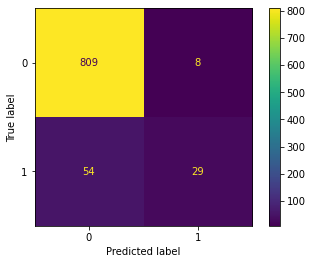

In [45]:
# plot confusion matrix
plot_confusion_matrix(true_pytorch, pred_pytorch)

In [46]:
# compute precision, recall, F-measure and support
print(classification_report(true_pytorch, pred_pytorch))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       817
           1       0.78      0.35      0.48        83

    accuracy                           0.93       900
   macro avg       0.86      0.67      0.72       900
weighted avg       0.92      0.93      0.92       900



In [47]:
# f1 score
f1_pytorch = f1_score(true_pytorch, pred_pytorch)
print('f1 score for PyTorch model:', round(f1_pytorch, 2))

f1 score for PyTorch model: 0.48


Due to the limited performance and memory of the computer, the pretrained BERT model is run on reduced data (3000 rows). Logistic regression model built in PySpark based on a neural network with one Linear layer and one Sigmoid function shows an accuracy of 0.98 for class 0 and 0.48 for class 1. F1 score = 0.48.

### Step 3. Text processing with Scikit-learn

In [48]:
# TF-IDF transformation
Image(url='https://www.twaino.com/wp-content/uploads/2021/12/3-Formule-mettant-en-relation-TF-IDF.jpg', 
      width=500, height=200)

In [50]:
# lemma tokenizer
class LemmaTokenizer(object):

    def __init__(self):
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    
    def __call__(self, text):
        return [self.lemmatizer.lemmatize(w) for w in self.w_tokenizer.tokenize(text)]

In [51]:
# text clarification
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join(text.split())
    return text

In [52]:
# clear the text
df_panda['text_cleared'] = df_panda.text.apply(clear_text)

In [53]:
# display cleared text
display(df_panda.head())

,text,label,count,text_cleared
0,Explanation\nWhy the edits made under my usern...,0,264,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,112,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,233,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,67,You sir are my hero Any chance you remember wh...


In [54]:
# split data into training and testing sets
X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(
    df_panda['text_cleared'], 
    df_panda['label'], 
    test_size=0.3, 
    random_state=777, 
    stratify=df_panda['label']
)

In [55]:
# print out size of datasets
print('Train size:', len(X_train_sklearn))
print('Test size:', len(X_test_sklearn))

Train size: 111504
Test size: 47788


In [56]:
# set pipeline 
pipeline_sklearn = PipelineSklearn([
    ('vect', CountVectorizerSklearn(tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegressionSklearn(multi_class='ovr', solver='lbfgs'))
])

In [57]:
# fit the model and make predictions
param_sklearn = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}
model_sklearn = GridSearchCV(pipeline_sklearn, param_sklearn, cv=5, verbose=1)
model_sklearn.fit(X_train_sklearn, y_train_sklearn)
pred_sklearn = model_sklearn.predict(X_test_sklearn)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


class 0 accuracy: 0.990
class 1 accuracy: 0.691


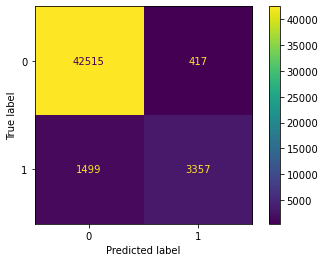

In [58]:
# plot confusion matrix
plot_confusion_matrix(y_test_sklearn, pred_sklearn)

In [59]:
# compute precision, recall, F-measure and support
print(classification_report(y_test_sklearn, pred_sklearn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42932
           1       0.89      0.69      0.78      4856

    accuracy                           0.96     47788
   macro avg       0.93      0.84      0.88     47788
weighted avg       0.96      0.96      0.96     47788



In [60]:
# f1 score
f1_sklearn = f1_score(y_test_sklearn, pred_sklearn)
print('f1 score for Sklearn model:', round(f1_sklearn, 2))

f1 score for Sklearn model: 0.78


The model in Scikit-learn is run on all available data without preprocessing and filtering. Vectorizer and TF-IDF are used to transform text into numerical data. Cross-validation and grid search are also used to improve performance. As a result, the model shows an accuracy of 0.99 for class 0 and 0.69 for class 1. F1 score = 0.78.

### Step 4. Text processing with PySpark

In [61]:
# N-gram model (bag of words)
Image(url='https://i.stack.imgur.com/7BXvM.png', 
      width=400, height=350)

In [62]:
# regular expression tokenizer
regex_tokenizer = RegexTokenizer(
    inputCol='text', 
    outputCol='words', 
    pattern='[\\W]'
)

count_vectors = CountVectorizerSpark(
    inputCol='words', 
    outputCol='features', 
    vocabSize=200000, 
    minDF=5
)

label_idx = StringIndexer(
    inputCol = 'label_', 
    outputCol = 'label'
) 

In [64]:
# set pipeline 
pipeline_pyspark = PipelineSpark(stages=[regex_tokenizer, count_vectors, label_idx])
pipeline_fit = pipeline_pyspark.fit(df_spark)
dataset = pipeline_fit.transform(df_spark)

In [65]:
# show results of tokinization and vectorization
dataset.show(5)

+--------------------+------+--------------------+--------------------+-----+
|                text|label_|               words|            features|label|
+--------------------+------+--------------------+--------------------+-----+
| just closure on ...|     0|[just, closure, o...|(15138,[0,1,5,15,...|  0.0|
|D'aww! He matches...|     0|[d, aww, he, matc...|(15138,[1,12,22,3...|  0.0|
|Hey man, I'm real...|     0|[hey, man, i, m, ...|(15138,[0,1,2,5,6...|  0.0|
|You, sir, are my ...|     0|[you, sir, are, m...|(15138,[3,9,15,17...|  0.0|
| use the tools we...|     0|[use, the, tools,...|(15138,[0,33,95,9...|  0.0|
+--------------------+------+--------------------+--------------------+-----+
only showing top 5 rows



In [66]:
# split data into training and testing sets
(train_data_pyspark, test_data_pyspark) = dataset.randomSplit([0.7, 0.3], seed=777)

In [67]:
# print out size of datasets
print('Train size: ' + str(train_data_pyspark.count()))
print('Test size: ' + str(test_data_pyspark.count()))

Train size: 57678
Test size: 24710


In [68]:
# create the model
lg = LogisticRegressionSpark(maxIter=20, regParam=0.3, elasticNetParam=0)

In [69]:
# create ParamGrid for Cross Validation
param_grid = (
    ParamGridBuilder()
    .addGrid(lg.regParam, [0.1, 0.5, 1, 2, 5, 10, 100, 1000])
    .addGrid(lg.elasticNetParam, [0.0, 0.1, 0.2])
    .build()
)

In [70]:
# create evaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='label',
    metricName='areaUnderROC'
)

In [71]:
# create 5-fold CrossValidator
cv = CrossValidator(
    estimator=lg, \
    estimatorParamMaps=param_grid, \
    evaluator=evaluator, \
    numFolds=5
)

In [72]:
# fit the model 
model_pyspark = cv.fit(train_data_pyspark)

In [73]:
# make predictions        
pred_pyspark = model_pyspark.transform(test_data_pyspark)
pred_pyspark.select('label', 'probability', 'prediction') \
            .orderBy('probability', ascending=False) \
            .show(n=5, truncate=30)

+-----+------------------------------+----------+
|label|                   probability|prediction|
+-----+------------------------------+----------+
|  1.0|                     [1.0,0.0]|       0.0|
|  0.0|[0.9999999997298625,2.70137...|       0.0|
|  1.0|[0.9999999952061449,4.79385...|       0.0|
|  0.0|[0.9999999816306065,1.83693...|       0.0|
|  0.0|[0.9999999772160665,2.27839...|       0.0|
+-----+------------------------------+----------+
only showing top 5 rows



In [74]:
# results evaluation
evaluator.evaluate(pred_pyspark)

0.6243000868222923

In [75]:
# convert pyspark data to pandas dataframe
results_pyspark = pred_pyspark.select('label', 'prediction').toPandas()

class 0 accuracy: 0.994
class 1 accuracy: 0.255


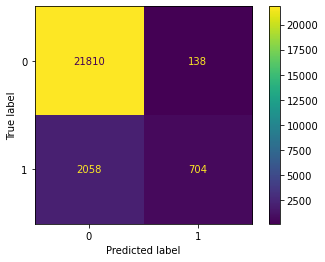

In [76]:
# plot confusion matrix
plot_confusion_matrix(results_pyspark['label'], results_pyspark['prediction'])

In [77]:
# compute precision, recall, F-measure and support
print(classification_report(results_pyspark['label'], results_pyspark['prediction']))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     21948
         1.0       0.84      0.25      0.39      2762

    accuracy                           0.91     24710
   macro avg       0.87      0.62      0.67     24710
weighted avg       0.91      0.91      0.89     24710



In [78]:
# f1 score
f1_pyspark = f1_score(results_pyspark['label'], results_pyspark['prediction'])
print('f1 score for PySpark model:', round(f1_pyspark, 2))

f1 score for PySpark model: 0.39


Due to problems with conversion, some of the data is filtered out. As a result, the model in PySpark is run on a piece of data. Tokenizer and Vectorizer are used to transform the text, and optimization is performed using cross-validation and grid search. The model shows an accuracy of 0.99 for class 0 and 0.24 for class 1. F1 score = 0.39.

### Results

In [80]:
# results table
results = [['PyTorch', f1_pytorch],
           ['Sklearn', f1_sklearn],
           ['PySpark', f1_pyspark]]
columns = ['Framework', 'f1 score']

results_table = pd.DataFrame(data=results, columns=columns)
display(results_table.sort_values(by='f1 score', ascending=False).reset_index(drop=True))

,Framework,f1 score
0,Sklearn,0.78
1,PyTorch,0.48
2,PySpark,0.39


### Conclusions

The PyTorch model has pretrained weights calculated with the BERT (Bidirectional Encoder Representations from Transformers) encoder and Logistic regression based on a single layer neural network. The text processing model uses masked language to have a fixed value independent of its context. BERT identifies a masked word based on context, whereby words are identified only by their surroundings.

In the Scikit-learn model, the statistical method TF-IDF (TF - term frequency, IDF - inverse document frequency) is applied to assess the importance of a word in the context of a document that is part of a corpus (collection of documents). The weight of a word is proportional to the frequency of the word's occurrence in the document and inversely proportional to the frequency of the word's occurrence in all documents in the collection.

The PySpark model applyes the Bag of Words method with the CountVectorizer function, which converts a corpus of texts into a vector, regardless of word order. The frequency of occurrence of each word is used as a feature for training the classifier.

The results show that all models for class 0 give high accuracy=0.98..0.99. With a small amount and imbalance of data, the PyTorch BERT pretrained model gives high results (0.98 and 0.42 for classes 0 and 1, respectively). The PySpark model is not very suitable for word processing. Even with cross-validation and grid search, the metric for class 1 is 0.24. For a relatively large amount of data with limited computer memory, the optimal solution is a model built in Scikit-learn, in which the accuracy for class 1 is 0.69.

Eventually, the target metric f1 greater than 0.75 is achieved only by the model in Scikit-learn (f1=0.78). This is due to doing research locally with limited CPU and memory capabilities. Additionally, the Scikit-learn framework allows for integration of third-party libraries into the data preprocessing and machine learning model, as well as functions and classes written in Python, unlike PySpark, which requires the use of UDF (user-defined functions). Despite the potentially higher metrics when running on a GPU, the model in PyTorch is highly dependent on pretrained weights, hence there is no flexibility in customizing for a specific task. Also, free cloud services are unstable. To apply a machine learning model in this NLP application, it is recommended to use the Scikit-learn framework.